# A2S Implementation 1 Data Analysis

In [592]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [574]:
pretest_df = pd.read_csv('data/pretest.csv')
posttest_df = pd.read_csv('data/posttest.csv')
key_df = pd.read_csv('data/key.csv')

key_df

,Question number,Question,Correct answer,Content type
0,1,Imagine you put a drop of paint in a glass of ...,free response,diffusion
1,2.1,Imagine you have a glass with hot water and an...,C,diffusion
2,2.2,Explain your choice,free response,diffusion
3,3,If you spray perfume/deodorant in the corder o...,A,diffusion
4,4,Once the perfume/deodorant particles reach the...,B,diffusion
5,5,Would the smell of perfume/deodorant make it a...,B,diffusion
6,6,The following choices are all acceptable defin...,B,modeling
7,7.1,Can a computer model represent real-world data...,B,modeling
8,7.2,Explain your choice:,free response,modeling
9,8a,Do you agree with this statement: Computer mod...,Disagree,modeling


In [575]:
all_data = pd.merge(pretest_df, posttest_df, on=["Last name", "First name", "Section", "Gender", "Reading Level Grade Equivalent", "Reading Level Distribution"], how="outer", suffixes=["_pre", "_post"])
# remove students not present both days
all_data = all_data[all_data.Present_pre]
all_data = all_data[all_data.Present_post]

In [576]:
# de-identify test data
student_data = all_data[["Last name", "First name", "Section", "Gender", "Reading Level Grade Equivalent", "Reading Level Distribution"]]
test_data = all_data.drop(["Last name", "First name", "Section", "Gender", "Reading Level Grade Equivalent", "Reading Level Distribution"], axis=1)
test_data

,Present_pre,1_pre,2.1_pre,2.2_pre,3_pre,4_pre,5_pre,6_pre,7.1_pre,7.2_pre,...,7.1_post,7.2_post,8a_post,8b_post,8c_post,9_post,10.1_post,10.2_post,11 (advantages)_post,11 (disadvantages)_post
0,True,I don't know?,no response,the cold glass of water.,C,D,C,B,B,No because computers are not perfect with that...,...,B,no because last time i tried it and it was not...,Agree,Agree,Disagree,A,A,if its not right they have to change it.,You can see what the real thing will look like,it's not the real thing and you will have to m...
1,True,no response,D,no response,no response,no response,no response,no response,no response,no response,...,A,Yes it can amalyze the data from the world on ...,Agree,Disagree,Agree,A,A,I mean if they don't like it I guess it depend...,NaN,NaN
2,True,I think once the paint touches the water the p...,C,I think when the water is warmer the particles...,A,C,B,C,A,I think yes because a person had programed it.,...,B,I don't think taht a computer would be able to...,Agree,Agree,Agree,A,A,"I think yes because they mifht teest, gather m...",You can use it as a visual when you can't see...,There might be mistakes and you would neeed to...
3,True,They push the water away and move into the spa...,C,Warmth expands so when it expands it will move...,B,A,C,B,B,I say this because perfection is very difficul...,...,B,No because the computer cant know everything l...,Disagree,Agree,Disagree,A,A,If they knew something was wrong they might ch...,You can do it anywhere,you cant measure perfectly.
4,True,Since the paint particles are not water i beco...,no response,I am not sure because I have not studyed it. S...,C,D,D,B,maybe,I do not agree with either because computer ca...,...,B,In the computer model the particles moved to f...,Disagree,Maybe,Maybe,A,A,Scientists always try to revise a model. To m...,You can simulate what would happen in the real...,Models can be wrong or it is not like the real...
5,True,Spead thour wate,A,hot water poably hot water burn,no response,no response,no response,no response,no response,no response,...,A,yes becasue it shows the same,Disagree,Disagree,Disagree,A,A,no response,becasue you can see the particle,how it was lagey
6,True,The paint would slowly desolve in the water an...,C,"I think that c. is the anser, I think this bec...",C,idk,C,D,A,I'm sort of in th emiddle but I thought I woul...,...,Maybe,I think a computer might be able to represent ...,Disagree,Agree,Disagree,A,A,I think a scientist would revise a modle so he...,You get to see everything thats happening easi...,"Models are not as procise as a computer, and t..."
7,True,I thnk when the paint hits the water it will s...,A/D,I'm not sure but I think it will spread faster...,D,D,D,A,no response,I dont understand what this question is asking,...,B,It is not the real world so I don't think it c...,Agree,Disagree,Disagree,A,A,Yes to improve it they would for sure revise it.,Can code quickly without having to physically ...,Is not as realistic and can glitch.
8,True,I think that the paint particles mix with the ...,C,I think c because hotter water helps make many...,A,C,B,A,B,"No, Because computers can't make very small de...",...,B,No. Because computers can make thinkgs look re...,Agree,Disagree,Disagree,A,A,"Yes, you can change a model, but it won't be l...","you can show your thinking, can be easy to use","can go not the way you want it, can glitch era..."
10,True,So I think in that drop of paint there's milo'...,A,"I think its A, because the hotter one will fas...",A,A/B,B,A,A,I said yes beause all you have to do is get th...,...,A,I said yes because all the things on a compute...,Agree,Agree,idk,A,A,I think yes because scientists have mode like ...,"you can it visual, it easeyer to explain","Its harder to explore, you can mess up"


In [577]:
constrained_response = []
for index, row in key_df.iterrows():
    if row["Correct answer"] != "free response":
        constrained_response.append(row["Question number"])

pre_constrained_response = [question_num + "_pre" for question_num in constrained_response]
post_constrained_response = [question_num + "_post" for question_num in constrained_response]
constrained_response_test_data = test_data[pre_constrained_response + post_constrained_response].copy()

In [578]:
for question_num in constrained_response:
    
    # mark correct/incorrect
    correct_response = key_df.loc[key_df["Question number"] == question_num]["Correct answer"].item()
    constrained_response_test_data[question_num + "_pre_correct"] = np.where(constrained_response_test_data[question_num + "_pre"] == correct_response, True, False)
    constrained_response_test_data[question_num + "_post_correct"] = np.where(constrained_response_test_data[question_num + "_post"] == correct_response, True, False)
    
    # determine change in correctness between tests
    conditions = [constrained_response_test_data[question_num + "_pre_correct"] == constrained_response_test_data[question_num + "_post_correct"], (constrained_response_test_data[question_num + "_pre_correct"] == False) & (constrained_response_test_data[question_num + "_post_correct"] == True), (constrained_response_test_data[question_num + "_pre_correct"] == True) & (constrained_response_test_data[question_num + "_post_correct"] == False)]
    choices = ["neutral", "positive", "negative"]
    constrained_response_test_data[question_num + "_change"] = np.select(conditions, choices, default=np.nan)

In [579]:
# disagregate by question type for future analysis
diffusion_df = key_df.loc[key_df["Content type"] == "diffusion"]
modeling_df = key_df.loc[key_df["Content type"] == "modeling"]
diffusion_constrainted_response = diffusion_df["Question number"].values
modeling_constrainted_response = modeling_df["Question number"].values
f1 = lambda x: x + "_pre"
f2 = lambda x: x + "_post"
f3 = lambda x: x + "_pre_correct"
f4 = lambda x: x + "_post_correct"
f5 = lambda x: x + "_change"
diffusion_constrained_response_cols = [question_num for question_num in constrained_response if question_num in diffusion_constrained_response]
diffusion_constrained_response_cols = [f(question_num) for question_num in diffusion_constrained_response_cols for f in [f1, f2, f3, f4, f5]]
modeling_constrained_response_cols = [question_num for question_num in constrained_response if question_num in modeling_constrained_response]
modeling_constrained_response_cols = [f(question_num) for question_num in modeling_constrained_response_cols for f in [f1, f2, f3, f4, f5]]
diffusion_constrained_response_test_data = constrained_response_test_data[diffusion_constrained_response_cols].copy()
modeling_constrained_response_test_data = constrained_response_test_data[modeling_constrained_response_cols].copy()

In [580]:
# score students
pre_cols = [question_num + "_correct" for question_num in pre_constrained_response]
constrained_response_test_data["pre_score"] = (constrained_response_test_data[pre_cols] == True).sum(1)/len(pre_cols)

post_cols = [question_num + "_correct" for question_num in post_constrained_response]
constrained_response_test_data["post_score"] = (constrained_response_test_data[post_cols] == True).sum(1)/len(post_cols)
constrained_response_test_data

,2.1_pre,3_pre,4_pre,5_pre,6_pre,7.1_pre,8a_pre,8b_pre,8c_pre,9_pre,...,8c_post_correct,8c_change,9_pre_correct,9_post_correct,9_change,10.1_pre_correct,10.1_post_correct,10.1_change,pre_score,post_score
0,no response,C,D,C,B,B,Agree,Agree,Agree,A,...,True,positive,True,True,neutral,True,True,neutral,0.454545,0.818182
1,D,no response,no response,no response,no response,no response,no response,no response,no response,no response,...,False,neutral,False,True,positive,False,True,positive,0.000000,0.363636
2,C,A,C,B,C,A,Disagree,Agree,Disagree,A,...,False,negative,True,True,neutral,True,True,neutral,0.727273,0.636364
3,C,B,A,C,B,B,Disagree,Agree,Agree,A,...,True,positive,True,True,neutral,True,True,neutral,0.636364,0.818182
4,no response,C,D,D,B,maybe,maybe,maybe,maybe,A,...,False,neutral,True,True,neutral,True,True,neutral,0.272727,0.727273
5,A,no response,no response,no response,no response,no response,no response,no response,no response,A,...,True,positive,True,True,neutral,True,True,neutral,0.181818,0.636364
6,C,C,idk,C,D,A,no response,no response,no response,no response,...,True,positive,False,True,positive,False,True,positive,0.090909,0.636364
7,A/D,D,D,D,A,no response,Agree/Disagree,Agree,Disagree,A,...,True,neutral,True,True,neutral,True,True,neutral,0.363636,0.727273
8,C,A,C,B,A,B,Disagree,Disagree,Disagree,A,...,True,neutral,True,True,neutral,True,True,neutral,0.727273,0.818182
10,A,A,A/B,B,A,A,no response,no response,no response,no response,...,False,neutral,False,True,positive,False,True,positive,0.181818,0.727273


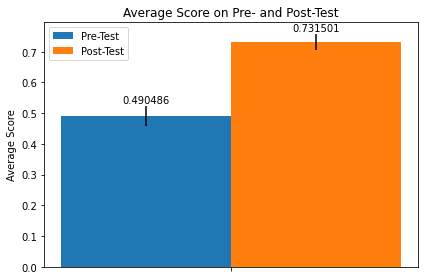

In [581]:
labels = ["Average"]

pre = [constrained_response_test_data["pre_score"].mean()]
pre_std_err = constrained_response_test_data["pre_score"].sem()
post = [constrained_response_test_data["post_score"].mean()]
post_std_err = constrained_response_test_data["post_score"].sem()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pre, width, yerr=[pre_std_err], label='Pre-Test')
rects2 = ax.bar(x + width/2, post, width, yerr=[post_std_err], label='Post-Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Score')
ax.set_title('Average Score on Pre- and Post-Test')
ax.set_xticks(x)
ax.set_xticklabels("")
ax.legend()

ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)

fig.set_facecolor("white")
fig.tight_layout()
plt.show()

## Distributions

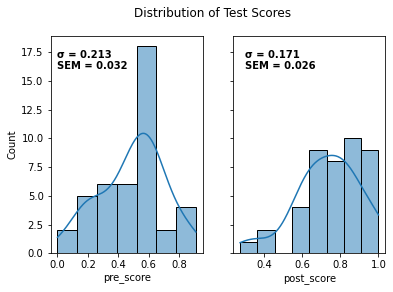

In [668]:
fig, ax = plt.subplots(1,2, sharey=True)
sns.histplot(constrained_response_test_data["pre_score"], kde=True, ax=ax[0])
std = constrained_response_test_data["pre_score"].std()
sem = constrained_response_test_data["pre_score"].sem()
ax[0].text(0,17, f"σ = {std:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax[0].text(0,16, f"SEM = {sem:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')

std = constrained_response_test_data["post_score"].std()
sem = constrained_response_test_data["post_score"].sem()
ax[1].text(0.3,17, f"σ = {std:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax[1].text(0.3,16, f"SEM = {sem:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')
sns.histplot(constrained_response_test_data["post_score"], kde = True, ax=ax[1])

fig.suptitle("Distribution of Test Scores")
fig.set_facecolor("white")


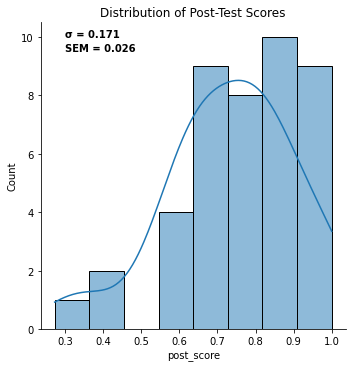

In [639]:
sns.displot(constrained_response_test_data["post_score"], kde = True)
std = constrained_response_test_data["post_score"].std()
sem = constrained_response_test_data["post_score"].sem()
plt.text(0.3,10, f"σ = {std:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.text(0.3,9.5, f"SEM = {sem:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.title("Distribution of Post-Test Scores")
plt.show()

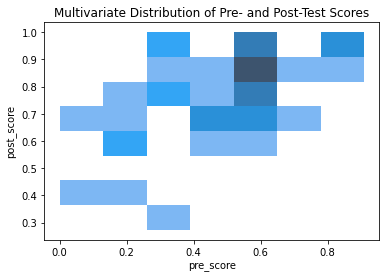

In [673]:
fig, ax = plt.subplots()
sns.histplot(x ='pre_score', y ='post_score', data = constrained_response_test_data, ax=ax)
plt.title("Multivariate Distribution of Pre- and Post-Test Scores")
fig.set_facecolor("white")

## By gender

In [582]:
girls_df = student_data.loc[student_data["Gender"] == "F"]
boys_df = student_data.loc[student_data["Gender"] == "M"]
girls_constrained_response_test_data = constrained_response_test_data.loc[constrained_response_test_data.index.isin(girls_df.index)]
boys_constrained_response_test_data = constrained_response_test_data.loc[constrained_response_test_data.index.isin(boys_df.index)]

[0.04113441402765899, 0.04832079187643332]


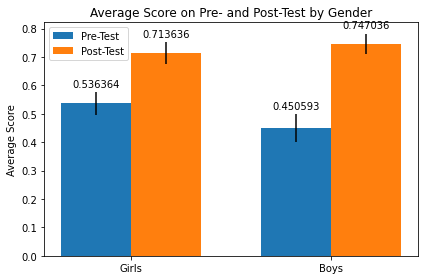

In [583]:
labels = ["Girls", "Boys"]

pre_means = [girls_constrained_response_test_data["pre_score"].mean(), boys_constrained_response_test_data["pre_score"].mean()]
pre_std_errs = [girls_constrained_response_test_data["pre_score"].sem(), boys_constrained_response_test_data["pre_score"].sem()]
post_means = [girls_constrained_response_test_data["post_score"].mean(), boys_constrained_response_test_data["post_score"].mean()]
post_std_errs = [girls_constrained_response_test_data["post_score"].sem(), boys_constrained_response_test_data["post_score"].sem()]

print(pre_std_errs)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pre_means, width, yerr=pre_std_errs, label='Pre-Test')
rects2 = ax.bar(x + width/2, post_means, width, yerr=post_std_errs, label='Post-Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Score')
ax.set_title('Average Score on Pre- and Post-Test by Gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
fig.set_facecolor("white")
plt.show()

## By class

In [584]:
am_df = student_data.loc[student_data["Section"] == "AM"]
pm_df = student_data.loc[student_data["Section"] == "PM"]
am_constrained_response_test_data = constrained_response_test_data.loc[constrained_response_test_data.index.isin(am_df.index)]
pm_constrained_response_test_data = constrained_response_test_data.loc[constrained_response_test_data.index.isin(pm_df.index)]

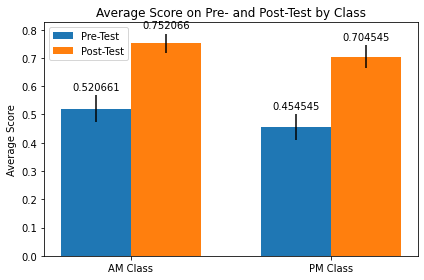

In [585]:
labels = ["AM Class", "PM Class"]

pre_means = [am_constrained_response_test_data["pre_score"].mean(), pm_constrained_response_test_data["pre_score"].mean()]
pre_std_errs = [am_constrained_response_test_data["pre_score"].sem(), pm_constrained_response_test_data["pre_score"].sem()]
post_means = [am_constrained_response_test_data["post_score"].mean(), pm_constrained_response_test_data["post_score"].mean()]
post_std_errs = [am_constrained_response_test_data["post_score"].sem(), pm_constrained_response_test_data["post_score"].sem()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pre_means, width, yerr=pre_std_errs, label='Pre-Test')
rects2 = ax.bar(x + width/2, post_means, width, yerr=post_std_errs, label='Post-Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Score')
ax.set_title('Average Score on Pre- and Post-Test by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
fig.set_facecolor("white")
plt.show()

## By question type

In [586]:
# score students
diffusion_pre_cols = [question_num + "_pre_correct" for question_num in diffusion_constrained_response]
diffusion_constrained_response_test_data["pre_score"] = (diffusion_constrained_response_test_data[diffusion_pre_cols] == True).sum(1)/len(diffusion_pre_cols)

modeling_pre_cols = [question_num + "_pre_correct" for question_num in modeling_constrained_response]
modeling_constrained_response_test_data["pre_score"] = (modeling_constrained_response_test_data[modeling_pre_cols] == True).sum(1)/len(modeling_pre_cols)

diffusion_post_cols = [question_num + "_post_correct" for question_num in diffusion_constrained_response]
diffusion_constrained_response_test_data["post_score"] = (diffusion_constrained_response_test_data[diffusion_post_cols] == True).sum(1)/len(diffusion_post_cols)

modeling_post_cols = [question_num + "_post_correct" for question_num in modeling_constrained_response]
modeling_constrained_response_test_data["post_score"] = (modeling_constrained_response_test_data[modeling_post_cols] == True).sum(1)/len(modeling_post_cols)


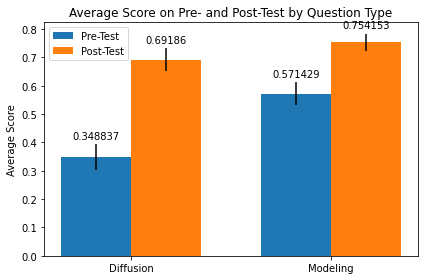

In [587]:
labels = ["Diffusion", "Modeling"]

pre_means = [diffusion_constrained_response_test_data["pre_score"].mean(), modeling_constrained_response_test_data["pre_score"].mean()]
pre_std_errs = [diffusion_constrained_response_test_data["pre_score"].sem(), modeling_constrained_response_test_data["pre_score"].sem()]
post_means = [diffusion_constrained_response_test_data["post_score"].mean(), modeling_constrained_response_test_data["post_score"].mean()]
post_std_errs = [diffusion_constrained_response_test_data["post_score"].sem(), modeling_constrained_response_test_data["post_score"].sem()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pre_means, width, yerr=pre_std_errs, label='Pre-Test')
rects2 = ax.bar(x + width/2, post_means, width, yerr=post_std_errs, label='Post-Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Score')
ax.set_title('Average Score on Pre- and Post-Test by Question Type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
fig.set_facecolor("white")
plt.show()

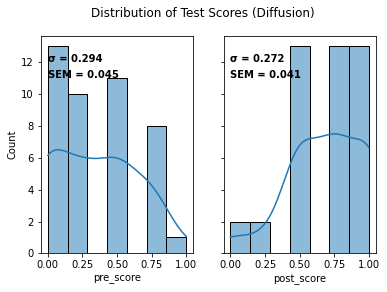

In [664]:
fig, ax = plt.subplots(1,2, sharey=True)
sns.histplot(diffusion_constrained_response_test_data["pre_score"], kde=True, ax=ax[0])
std = diffusion_constrained_response_test_data["pre_score"].std()
sem = diffusion_constrained_response_test_data["pre_score"].sem()
ax[0].text(0,12, f"σ = {std:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax[0].text(0,11, f"SEM = {sem:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')

std = diffusion_constrained_response_test_data["post_score"].std()
sem = diffusion_constrained_response_test_data["post_score"].sem()
ax[1].text(0,12, f"σ = {std:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax[1].text(0,11, f"SEM = {sem:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')
sns.histplot(diffusion_constrained_response_test_data["post_score"], kde = True, ax=ax[1])

fig.suptitle("Distribution of Test Scores (Diffusion)")
fig.set_facecolor("white")


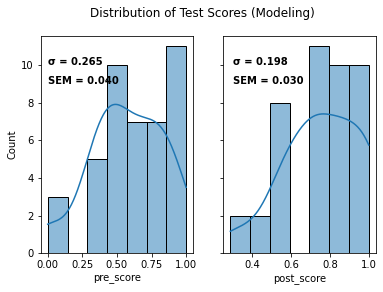

In [665]:
fig, ax = plt.subplots(1,2, sharey=True)
sns.histplot(modeling_constrained_response_test_data["pre_score"], kde=True, ax=ax[0])
std = modeling_constrained_response_test_data["pre_score"].std()
sem = modeling_constrained_response_test_data["pre_score"].sem()
ax[0].text(0,10, f"σ = {std:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax[0].text(0,9, f"SEM = {sem:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')

std = modeling_constrained_response_test_data["post_score"].std()
sem = modeling_constrained_response_test_data["post_score"].sem()
ax[1].text(0.3,10, f"σ = {std:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax[1].text(0.3,9, f"SEM = {sem:.3f}", horizontalalignment='left', size='medium', color='black', weight='semibold')
sns.histplot(modeling_constrained_response_test_data["post_score"], kde = True, ax=ax[1])

fig.suptitle("Distribution of Test Scores (Modeling)")
fig.set_facecolor("white")


## By reading level

In [588]:
below_df = student_data.loc[student_data["Reading Level Distribution"] == "below"]
at_df = student_data.loc[student_data["Reading Level Distribution"] == "grade level"]
above_df = student_data.loc[student_data["Reading Level Distribution"] == "above"]
below_constrained_response_test_data = constrained_response_test_data.loc[constrained_response_test_data.index.isin(below_df.index)]
at_constrained_response_test_data = constrained_response_test_data.loc[constrained_response_test_data.index.isin(at_df.index)]
above_constrained_response_test_data = constrained_response_test_data.loc[constrained_response_test_data.index.isin(above_df.index)]

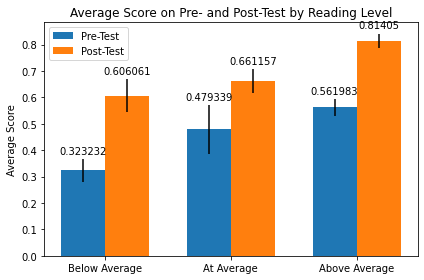

In [589]:
labels = ["Below Average", "At Average", "Above Average"]

pre_means = [below_constrained_response_test_data["pre_score"].mean(), at_constrained_response_test_data["pre_score"].mean(), above_constrained_response_test_data["pre_score"].mean()]
pre_std_errs = [below_constrained_response_test_data["pre_score"].sem(), at_constrained_response_test_data["pre_score"].sem(), above_constrained_response_test_data["pre_score"].sem()]
post_means = [below_constrained_response_test_data["post_score"].mean(), at_constrained_response_test_data["post_score"].mean(), above_constrained_response_test_data["post_score"].mean()]
post_std_errs = [below_constrained_response_test_data["post_score"].sem(), at_constrained_response_test_data["post_score"].sem(), above_constrained_response_test_data["post_score"].sem()]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pre_means, width, yerr=pre_std_errs, label='Pre-Test')
rects2 = ax.bar(x + width/2, post_means, width, yerr=post_std_errs, label='Post-Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Score')
ax.set_title('Average Score on Pre- and Post-Test by Reading Level')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
fig.set_facecolor("white")
plt.show()

# Workspace

In [382]:
questions_dict = {}
for question_num in constrained_response:
    question_df = test_data[[question_num + "_pre", question_num + "_post"]]
    question_df.columns = ["Pretest response", "Posttest response"]
    
    # mark correct/incorrect
    correct_response = key_df.loc[key_df["Question number"] == question_num]["Correct answer"].item()
    question_df["pre_correct"] = np.where(question_df["Pretest response"] == correct_response, True, False)
    question_df["post_correct"] = np.where(question_df["Posttest response"] == correct_response, True, False)
    
    # determine change in correctness between tests
    conditions = [question_df["pre_correct"] == question_df["post_correct"], (question_df["pre_correct"] == False) & (question_df["post_correct"] == True), (question_df["pre_correct"] == True) & (question_df["post_correct"] == False)]
    choices = ["neutral", "positive", "negative"]
    question_df["change"] = np.select(conditions, choices, default=np.nan)
    
    # add the df
    questions_dict[question_num] = question_df

/var/folders/gw/zzdm1k1s4czgdmpvkm7g_0q80000gn/T/ipykernel_62907/4076370194.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_df["pre_correct"] = np.where(question_df["Pretest response"] == correct_response, True, False)
/var/folders/gw/zzdm1k1s4czgdmpvkm7g_0q80000gn/T/ipykernel_62907/4076370194.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_df["post_correct"] = np.where(question_df["Posttest response"] == correct_response, True, False)
/var/folders/gw/zzdm1k1s4czgdmpvkm7g_0q80000gn

## Disagregation by question

In [383]:
summary_stats_df = pd.DataFrame(columns=['question_num', 'total_responses', 
                                         'count_pre_correct', 'percent_pre_correct', 
                                         'count_pre_incorrect', 'percent_pre_incorrect',
                                         'count_post_correct', 'percent_post_correct', 
                                         'count_post_incorrect', 'percent_post_incorrect',
                                         'count_positive_change', 'percent_positive_change',
                                         'count_negative_change', 'percent_negative_change',
                                         'count_no_change', 'percent_no_change'])

for question_num, question_df in questions_dict.items():
    total_responses = len(question_df["Pretest response"])

    count_pre_correct = len(question_df.loc[question_df["pre_correct"]])
    percent_pre_correct = count_pre_correct/total_responses
    count_pre_incorrect = len(question_df.loc[question_df["pre_correct"] == False])
    percent_pre_incorrect = count_pre_incorrect/total_responses
    
    count_post_correct = len(question_df.loc[question_df["post_correct"]])
    percent_post_correct = count_post_correct/total_responses
    count_post_incorrect = len(question_df.loc[question_df["post_correct"] == False])
    percent_post_incorrect = count_post_incorrect/total_responses

    count_positive_change = len(question_df.loc[question_df["change"] == "positive"])
    percent_positive_change = count_positive_change/total_responses
    count_negative_change = len(question_df.loc[question_df["change"] == "negative"])
    percent_negative_change = count_negative_change/total_responses
    count_no_change = len(question_df.loc[question_df["change"] == "neutral"])
    percent_no_change = count_no_change/total_responses
    
    summary_stats_df.loc[len(summary_stats_df)] = [question_num, total_responses, 
                                                  count_pre_correct, percent_pre_correct,
                                                  count_pre_incorrect, percent_pre_incorrect,
                                                  count_post_correct, percent_post_correct,
                                                  count_post_incorrect, percent_post_incorrect,
                                                  count_positive_change, percent_positive_change,
                                                  count_negative_change, percent_negative_change,
                                                  count_no_change, percent_no_change]

In [384]:
summary_stats_df

,question_num,total_responses,count_pre_correct,percent_pre_correct,count_pre_incorrect,percent_pre_incorrect,count_post_correct,percent_post_correct,count_post_incorrect,percent_post_incorrect,count_positive_change,percent_positive_change,count_negative_change,percent_negative_change,count_no_change,percent_no_change
0,2.1,43,19,0.441860,24,0.558140,39,0.906977,4,0.093023,21,0.488372,1,0.023256,21,0.488372
1,3,43,19,0.441860,24,0.558140,31,0.720930,12,0.279070,13,0.302326,1,0.023256,29,0.674419
2,4,43,9,0.209302,34,0.790698,25,0.581395,18,0.418605,18,0.418605,2,0.046512,23,0.534884
3,5,43,13,0.302326,30,0.697674,24,0.558140,19,0.441860,14,0.325581,3,0.069767,26,0.604651
4,6,43,13,0.302326,30,0.697674,23,0.534884,20,0.465116,13,0.302326,3,0.069767,27,0.627907
5,7.1,43,21,0.488372,22,0.511628,35,0.813953,8,0.186047,15,0.348837,1,0.023256,27,0.627907
6,8a,43,22,0.511628,21,0.488372,27,0.627907,16,0.372093,9,0.209302,4,0.093023,30,0.697674
7,8b,43,18,0.418605,25,0.581395,25,0.581395,18,0.418605,10,0.232558,3,0.069767,30,0.697674
8,8c,43,27,0.627907,16,0.372093,33,0.767442,10,0.232558,10,0.232558,4,0.093023,29,0.674419
9,9,43,35,0.813953,8,0.186047,43,1.000000,0,0.000000,8,0.186047,0,0.000000,35,0.813953


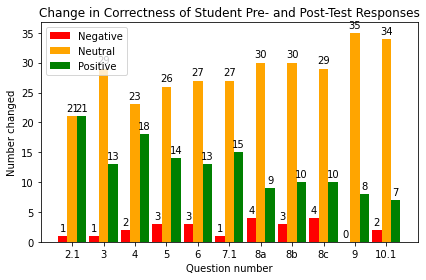

In [385]:
labels = summary_stats_df['question_num']

negative_change = summary_stats_df['count_negative_change']
no_change = summary_stats_df['count_no_change']
positive_change = summary_stats_df['count_positive_change']

x = np.arange(2*len(labels), step=2)  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, negative_change, width, label='Negative', color="red")
rects2 = ax.bar(x, no_change, width, label='Neutral', color="orange")
rects3 = ax.bar(x + width, positive_change, width, label='Positive', color="green")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number changed')
ax.set_title('Change in Correctness of Student Pre- and Post-Test Responses')
ax.set_xlabel('Question number')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()
plt.show()